In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import pprint
from matplotlib import patches

In [2]:
df = pd.read_pickle("./data.pkl") 
print(df.shape)

(1024, 13)


#### 13 columns: 1st column is time (independent var.), 2nd column is uncertainty (in m/s), col 3-13 are datasets (units m/s)

## Q1. Fit to sinusoidal function of type <font color='blue'>$A_1 cos(2\pi t/T_0) + A_2 sin(2\pi t/T_0) + B$</font>

#### a) Fit to the signal above. One can do it by linear algebra, as was done in pset01. Or, just use scipy's routine. The answers should be the same. The plots below show the maximum likelihood estimator values for $A_1, A_2, B$.
#### P.S. I chose to do it this way because that's how I would do it in real life, but if you want me to perform the linear algebra operations, I can do that too.
#### b) To estimate uncertainties in fit parameters, we obtain the Hessian, which is the second partial derivative of the fit function wrt each fit parameter. The covariance matrix is the inverse of the Hessian.

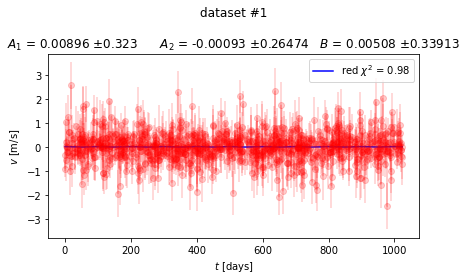

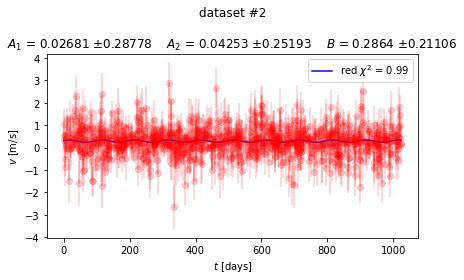

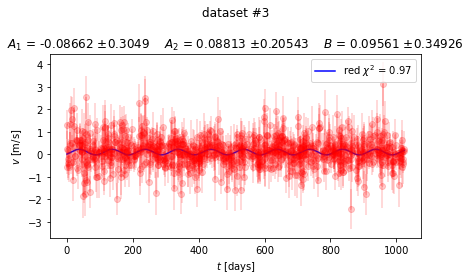

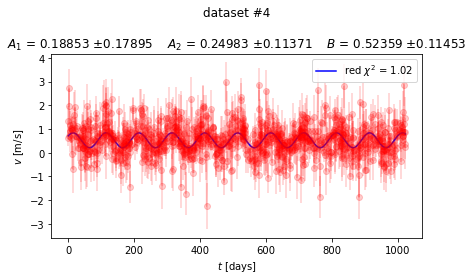

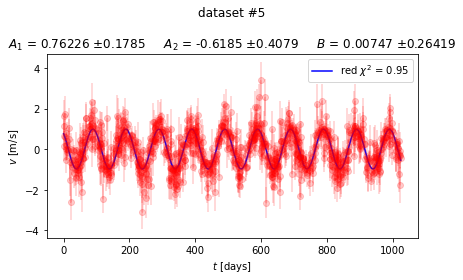

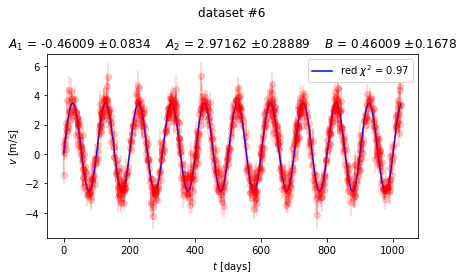

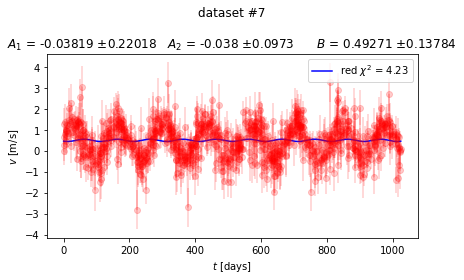

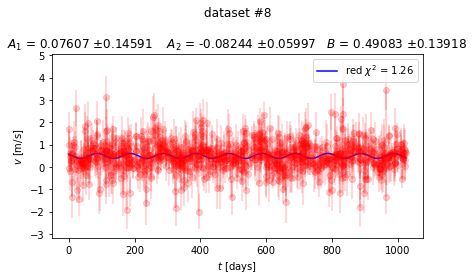

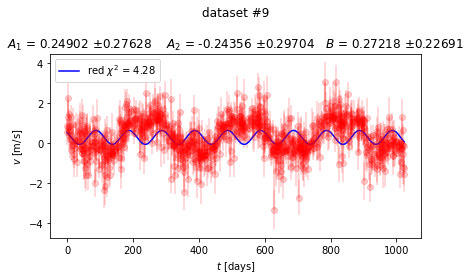

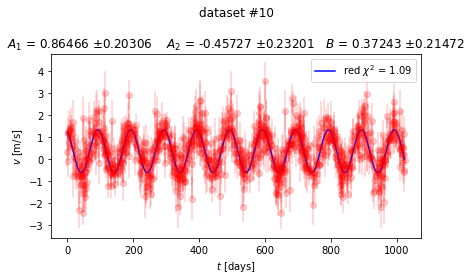

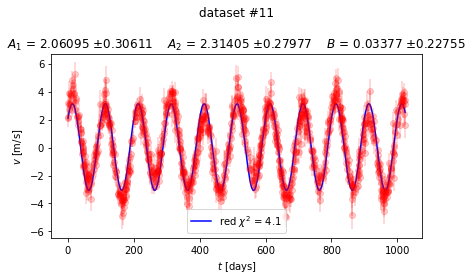

In [79]:
params_dict = {} #save fit parameters here

#plot dataset
for i in range(2,13):
    
    X_data = df[:,0]
    Y_data_err = df[:,1]
    Y_data = df[:,i]
    
    fig, ax = plt.subplots()
    ax.errorbar(X_data,Y_data,yerr = Y_data_err, marker = 'o', c = 'red', alpha = 0.2)
    
    #minimize chi_sq. Remember chi_sq is -2*LL
    #I know there are more efficient ways to do rather than having the function in the for loop, but I did that
        #because minimize function takes in the model, and parameters as next argument. Not sure how to re-write
        #with info and data.
    T0 = 100
    def chi_sq(params):
        A1, A2, B = params[0], params[1], params[2]
        y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B\
                for i in range(len(X_data))]
        func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
        ans = np.sum(func_list)
        return ans
              
    LL_model = minimize(chi_sq, np.array([1,1,1]), method = 'L-BFGS-B')
    A1, A2, B = LL_model.x[0], LL_model.x[1], LL_model.x[2]
        
    #deal with uncertainties
    covar = LL_model.hess_inv
    covar = covar * np.identity(covar.shape[1]) 
    A1_err = np.sqrt(covar[0][0])
    A2_err = np.sqrt(covar[1][1])
    B_err = np.sqrt(covar[2][2])
    
    #save information to dictionary:
    params_dict[i-1] = [A1, A2, B]
    
    y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B\
                for i in range(len(X_data))]
    ax.plot(X_data, y_fit, 'b-', label = r'red $\chi^2$ = {}'.format(round((chi_sq([A1, A2, B])/(len(X_data) -1)),2)))

    str1 = 'dataset #{}\n'.format(i-1) + '\n'
    str2 = r'$A_1$ = {} $\pm$'.format(round(A1,5)) + '{}'.format(round(A1_err,5)) + '\t'
    str3 = r'$A_2$ = {} $\pm$'.format(round(A2,5)) + '{}'.format(round(A2_err,5)) + '\t'
    str4 = r'$B$ = {} $\pm$'.format(round(B,5)) + '{}'.format(round(B_err,5))
    ax.set_title(str1 + str2 + str3 + str4)
    ax.set_xlabel(r'$t$ [days]')
    ax.set_ylabel(r'$v$ [m/s]')
    ax.legend()

    plt.tight_layout()

## Q2. Fit to sinusoidal function of type <font color='blue'>$ A_1 cos(2\pi t/T_0) + A_2 sin(2\pi t/T_0) + A_3 cos(2\pi t/T_1) + A_4 sin(2\pi t/T_1) + B$ </font>

#### Fitting in this manner would not work well (because we now have many parameters, one of which is highly non-trivial to solve for). So let's do brute force.
#### We profile out the nuisance by calculating likelihood at different values of $T_1$. Obtain fit parameters for $A_3, A_4$, while using the values for $A_1, A_2, B$ obtained in Q1. And then, obtain likelihood values for different $T_1$.

In [80]:
def get_period(i):
    
    T_list = np.append(np.linspace(1,80,80), np.linspace(120,400,281)) #append two arrays that exclude the
        #T=100 region.

    X_data = df[:,0]
    Y_data_err = df[:,1]
    Y_data = df[:,i]

    likelihood = []
    for T1 in T_list:
        #calc. chi_sq
        def chi_sq(params):
            A1, A2, B = params_dict[i-1][0], params_dict[i-1][1], params_dict[i-1][2]
            A3, A4 = params[0], params[1]
            y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B + \
                     A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1) \
                     for i in range(len(X_data))]
            func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
            ans = np.sum(func_list)
            return ans
        LL_model = minimize(chi_sq, np.array([1,1]), method = 'L-BFGS-B') #minimize chi-square
        A3, A4 = LL_model.x[0], LL_model.x[1]
        likelihood.append(-1/2*chi_sq([A3, A4]))

    index_max = max(range(len(likelihood)), key=likelihood.__getitem__)
    
    #deal with uncertainties
    covar = LL_model.hess_inv
    covar = covar * np.identity(covar.shape[1]) 
    A3_err = np.sqrt(covar[0][0])
    A4_err = np.sqrt(covar[1][1])    

    fig, ax = plt.subplots()
    ax.plot(T_list, likelihood,'k--')
    ax.scatter([T_list[index_max]],[likelihood[index_max]],marker = 'o', c='red',\
               label = r'T1 = {} days'.format(round(T_list[index_max],2)))
    ax.set_xlabel('T [days]')
    ax.set_ylabel('Log-Likelihood')
    str1 = 'dataset #{}\n'.format(i-1) + '\n'
    str2 = r'$A_3$ = {} $\pm$'.format(round(A3,5)) + '{}'.format(round(A3_err,5)) + '\t'
    str3 = r'$A_4$ = {} $\pm$'.format(round(A4,5)) + '{}'.format(round(A4_err,5))
    ax.set_title(str1+str2+str3)

    
    rectangle = patches.Rectangle((80, min(likelihood)), 40, abs(max(likelihood) - min(likelihood)), edgecolor='None',\
                                  facecolor="orange", zorder=2, label = 'excluded')
    ax.add_patch(rectangle)
    
    #update parameters dictionary
    L = params_dict[i-1]
    L.extend([A3,A4,T_list[index_max]])
    
    _=ax.legend()

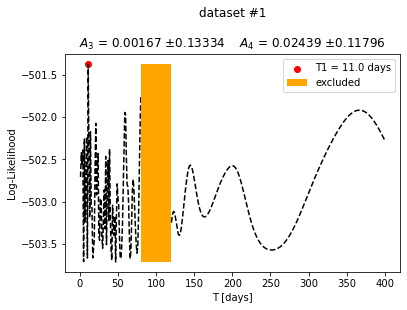

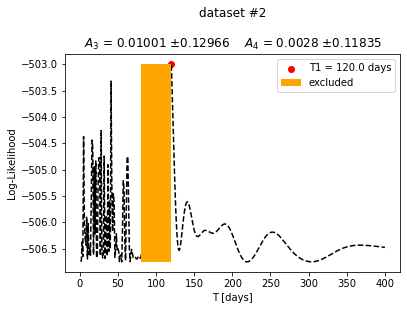

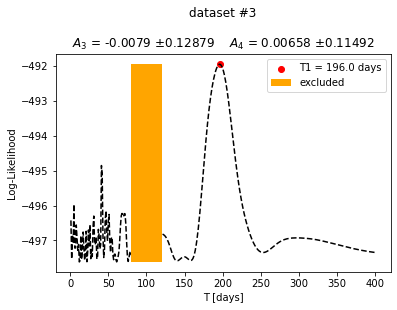

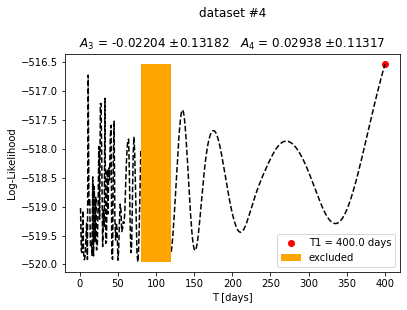

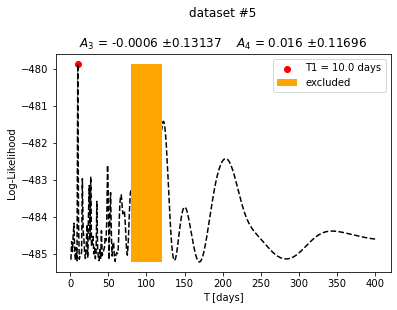

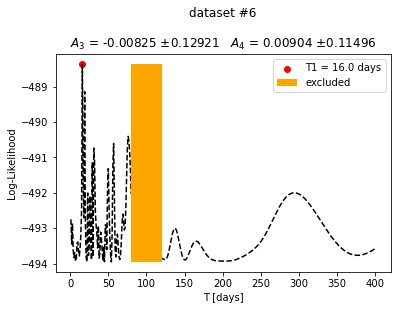

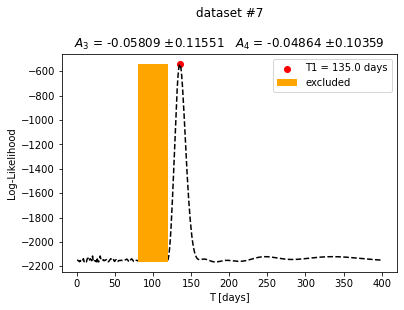

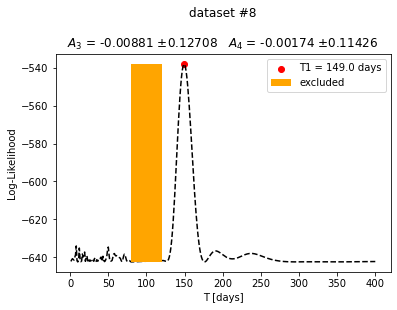

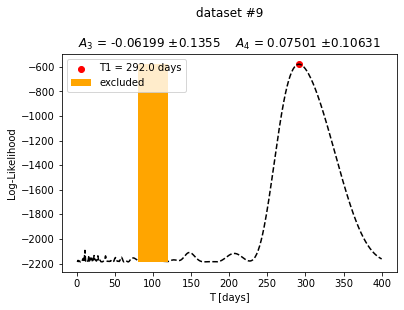

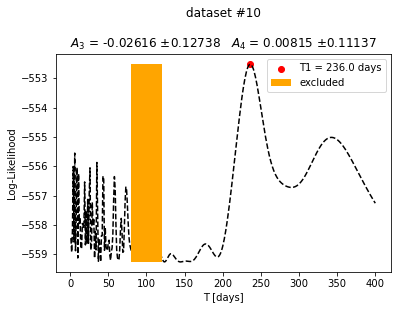

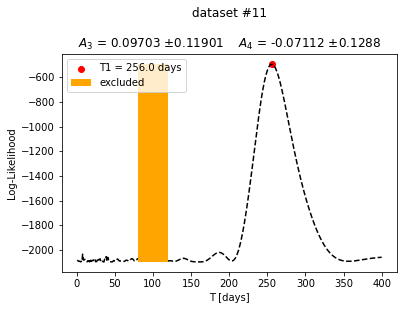

In [81]:
for i in range(2,13):
    get_period(i)

In [82]:
print(params_dict)

{1: [0.00895929795939929, -0.0009323793740367533, 0.0050815233784881515, 0.0016749338128239188, 0.024388859545279164, 11.0], 2: [0.026806845876480176, 0.04253465174182918, 0.2864030881566427, 0.010006336967800265, 0.0027983246175870024, 120.0], 3: [-0.08662208099787798, 0.08813394451187159, 0.09560586913939731, -0.00790292313559583, 0.006583952625967638, 196.0], 4: [0.18853249256051896, 0.24983258057107732, 0.5235855219602398, -0.02203758526940516, 0.029380533298315425, 400.0], 5: [0.7622605514808514, -0.6185043439210638, 0.007465061881816828, -0.0006048236151557698, 0.016003669643696178, 10.0], 6: [-0.4600899844871463, 2.9716240065271737, 0.4600945288612138, -0.008250764845605054, 0.009035983800652521, 16.0], 7: [-0.03818780562375731, -0.037996355452966965, 0.4927122455812657, -0.05809251191635814, -0.04863705972843044, 135.0], 8: [0.07607086719082504, -0.0824442837612129, 0.49082787767644775, -0.008810272019655016, -0.0017408275938947141, 149.0], 9: [0.24901581234424097, -0.243561982

#### Perform one more set of fits! We now have MLE for $A_3, A_4, T_1$ and from Q1) we have MLE for $A_1, A_2, B$. But the MLE values for $A_1, A_2, B$ were used to obtain MLE for $A_3, A_4, T_1$. So, now we can try a 6-parameter fit by using all of these MLEs as initial values. Convergence should be way faster considering initial estimates are close to true values!

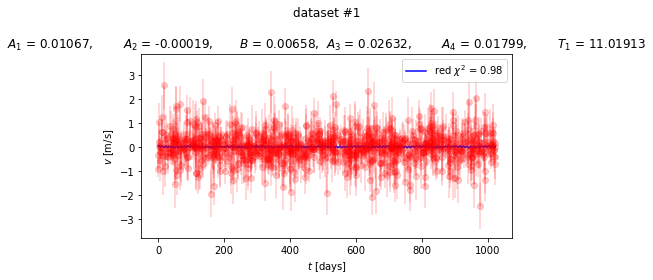

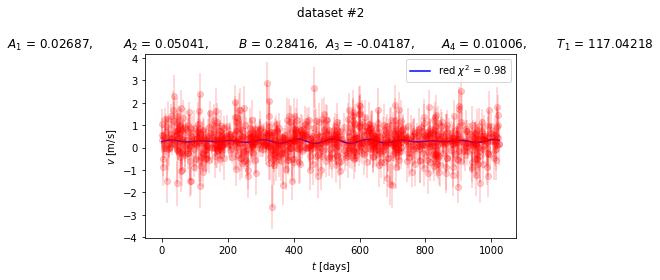

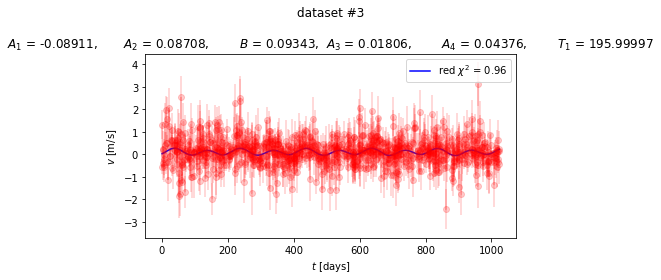

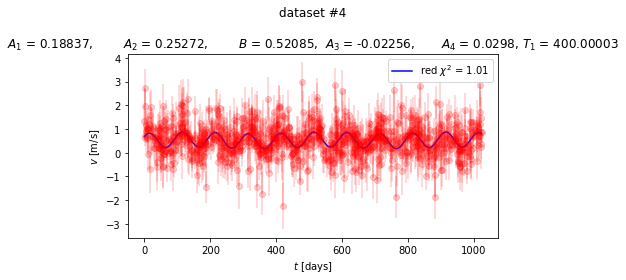

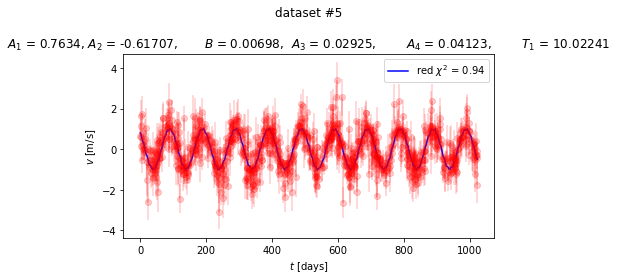

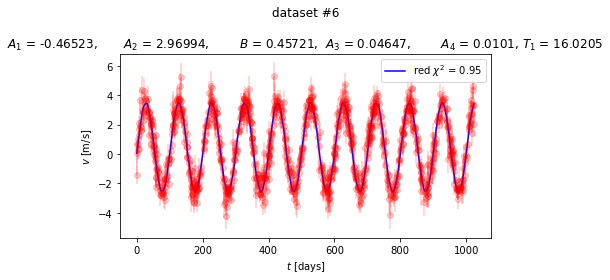

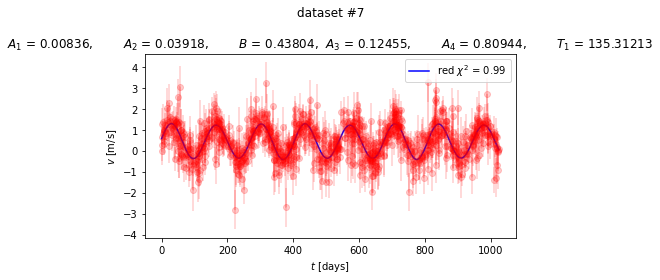

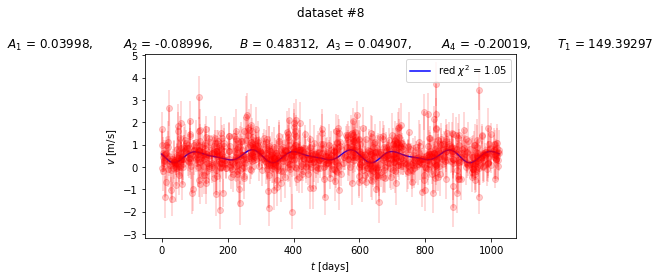

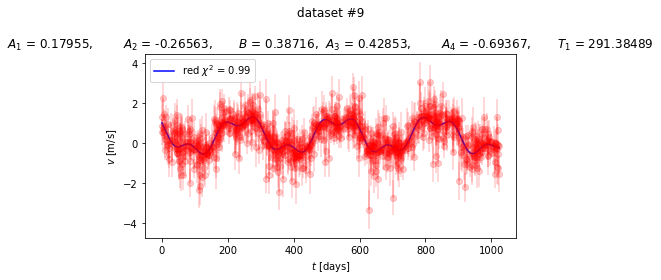

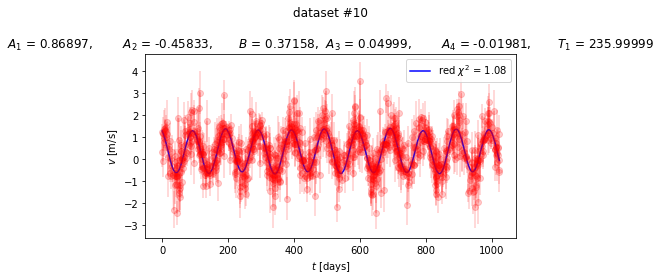

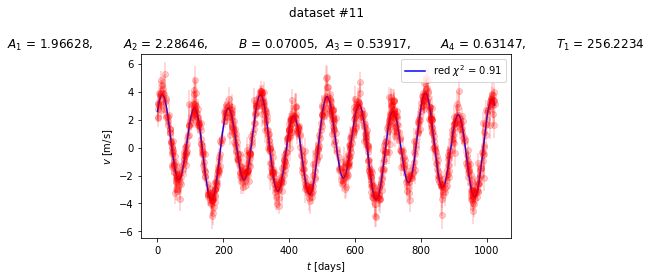

In [93]:
for i in range(2,13):
    
    X_data = df[:,0]
    Y_data_err = df[:,1]
    Y_data = df[:,i]
    
    fig, ax = plt.subplots()
    ax.errorbar(X_data,Y_data,yerr = Y_data_err, marker = 'o', c = 'red', alpha = 0.2)
    
    T0 = 100
    def chi_sq(params):
        A1, A2, B, A3, A4, T1 = params[0], params[1], params[2], params[3], params[4], params[5]
        y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B +\
                 A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1)\
                for i in range(len(X_data))]
        func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
        ans = np.sum(func_list)
        return ans
              
    p0 = params_dict[i-1] #obtain initial estimates from earlier fits
    LL_model = minimize(chi_sq, np.array(p0), method = 'L-BFGS-B')
    A1, A2, B, A3, A4, T1 = LL_model.x[0], LL_model.x[1], LL_model.x[2], LL_model.x[3], LL_model.x[4], LL_model.x[5]
        
    #deal with uncertainties
    covar = LL_model.hess_inv
    covar = covar * np.identity(covar.shape[1]) 
    
    y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B +\
             A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1)\
                for i in range(len(X_data))]
    ax.plot(X_data, y_fit, 'b-', label = r'red $\chi^2$ = {}'.format(round((chi_sq([A1, A2, B, A3, A4, T1])/(len(X_data) -1)),2)))

    str1 = 'dataset #{}\n'.format(i-1) + '\n'
    str2 = r'$A_1$ = {},'.format(round(A1,5)) + '\t'
    str3 = r'$A_2$ = {},'.format(round(A2,5)) + '\t'
    str4 = r'$B$ = {},'.format(round(B,5)) + '\t'
    str5 = r'$A_3$ = {},'.format(round(A3,5)) + '\t'
    str6 = r'$A_4$ = {},'.format(round(A4,5)) + '\t'
    str7 = r'$T_1$ = {}'.format(round(T1,5))

    ax.set_title(str1 + str2 + str3 + str4 + str5 + str6 + str7)
    ax.set_xlabel(r'$t$ [days]')
    ax.set_ylabel(r'$v$ [m/s]')
    ax.legend()

    plt.tight_layout()

#### Has the inclusion of these nuisance parameters changed the fits?
#### Absolutely, in some cases! In other cases, not really. A good way to compare would be to evaluate likelihood ratios, or the difference between log-likelihoods. $\chi^2$ values are just -2LL. So, if $\chi^2$ is significantly lower, we can conclude that the fits have changed. Just use difference in reduced $\chi^2$ as a proxy for delta log-likelihood.
#### If we set threshold for $\Delta \chi^2$ (reduced) to be at least 3 for any significant change, then we would conclude that the following datasets have at least two signals:
#### Dataset #7, #9, #11